In [1]:
from similarity_scoring import BertSimilarityModel
from transformers import pipeline
import json
from torch.utils.data import Dataset, random_split, DataLoader, RandomSampler, SequentialSampler
import numpy as np

c:\Users\Bruger\miniconda3\envs\nlp_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cap = "A blue bird"
poem = "Their feathers too bright \ntheir songs too sweet and wild"

In [3]:
sim_model = BertSimilarityModel(no_hidden_layers=1, hidden_dim=25, max_length=25)
image2text = pipeline("image-to-text", model="nlpconnect/vit-gpt2-image-captioning")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
c:\Users\Bruger\miniconda3\envs\nlp_env\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


**Input for the BERT Tokenizer**

In [4]:
encoding = sim_model.encode_input(cap, poem)
for key in encoding.keys():
    print(key,":",encoding[key])
tokens = sim_model.tokenizer.convert_ids_to_tokens(encoding["input_ids"].numpy()[0])
print("tokens :",tokens)

input_ids : tensor([[  101,  1037,  2630,  4743,   102,  2037, 12261,  2205,  4408,  2037,
          2774,  2205,  4086,  1998,  3748,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0]])
token_type_ids : tensor([[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0]])
attention_mask : tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0]])
tokens : ['[CLS]', 'a', 'blue', 'bird', '[SEP]', 'their', 'feathers', 'too', 'bright', 'their', 'songs', 'too', 'sweet', 'and', 'wild', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


**Initial similarity**

In [5]:
similarity = sim_model.similarity(cap, poem)

print(similarity)

The BERT classifier has not been trained yet. Similarity might not be good.
tensor([[0.4892]], grad_fn=<SigmoidBackward0>)


**A dataset**

In [6]:
with open("../../data/multim_poem.json") as f:
    jsonfile = json.load(f)

print("Data length:",len(jsonfile))

Data length: 8292


In [7]:
N = 20
data = [{}]*N
i,j = 0,0
while j < N and i < len(jsonfile):
    # print("step :",i)
    try:
        desc = image2text(jsonfile[i]['image_url'])
    except:
        # skip image
        i += 1
        continue
    desc = desc[0]['generated_text']
    
    data[j] = jsonfile[i]
    data[j]["caption"] = desc
    i += 1 
    j += 1 

c:\Users\Bruger\miniconda3\envs\nlp_env\lib\site-packages\transformers\generation\utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


In [8]:
class CaptionPoemDataset(Dataset):
    def __init__(self, datadict):
        self.data = datadict
        
        self.N_halfs = len(self.data) // 2 
        self.shuffle_idx = np.random.choice(a=self.N_halfs, size=self.N_halfs, replace=False)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if idx < self.N_halfs:
            # match caption idx, with poem shuffle idx 
            match_idx = self.shuffle_idx[idx]
        else:
            match_idx = idx
        cap_poem = [self.data[idx]['caption'], self.data[match_idx]['poem']]
        label = 1 if idx == match_idx else 0 
        return cap_poem, label

dataset = CaptionPoemDataset(data)

In [9]:
# Split data into train and validation sets
SPLIT = 0.9
train_size = int(SPLIT*len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
print("Number of samples for training =", train_size)
print("Number of samples for validation =", val_size)

Number of samples for training = 18
Number of samples for validation = 2


In [15]:
BATCH_SIZE = 1
train_dataloader = DataLoader(train_dataset,
                              sampler=RandomSampler(train_dataset),
                              batch_size=BATCH_SIZE)

val_dataloader = DataLoader(val_dataset,
                            sampler=SequentialSampler(val_dataset),
                            batch_size=BATCH_SIZE)

Iteration: 1 	 Loss: 0.8150061368942261 	
Iteration: 2 	 Loss: 0.8236148953437805 	
Iteration: 3 	 Loss: 0.8108645081520081 	
Iteration: 4 	 Loss: 0.8064420819282532 	
Iteration: 5 	 Loss: 0.787864089012146 	
Iteration: 6 	 Loss: 0.837028443813324 	
Iteration: 7 	 Loss: 0.7788386344909668 	
Iteration: 8 	 Loss: 0.7782682180404663 	
Iteration: 9 	 Loss: 0.7963189482688904 	
Iteration: 10 	 Loss: 0.781745970249176 	


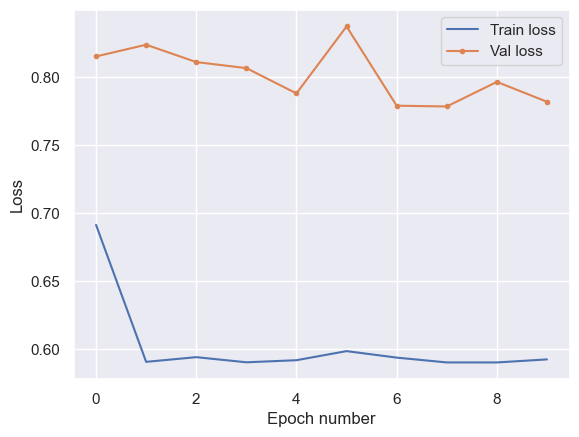

In [18]:
loss, val_loss = sim_model.train_bert_classifier(train_dataloader, val_dataloader, num_epochs=10, val_epoch=1, learning_rate=0.001, verbose=True)

In [20]:
similarity = sim_model.similarity(cap, poem)

print(similarity)

tensor([[0.4589]], grad_fn=<SigmoidBackward0>)
